<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/2d_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal:
- implement 2d classification a la Nelson, 2019

# TODO:
- speed up (numba). bottle neck is `make_fake`. need to make `np.roll` jittable

# Generate fake data

In [0]:
import numpy as np
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt
import numba
import seaborn as sns


In [0]:
N = 32+1

X_ = np.linspace(-N-1/2, N-1/2, N)
Y = np.linspace(-N-1/2, N-1/2, N)
X_, Y = np.meshgrid(X_, Y)

pos = np.empty(X_.shape + (2,))
pos[:, :, 0] = X_
pos[:, :, 1] = Y

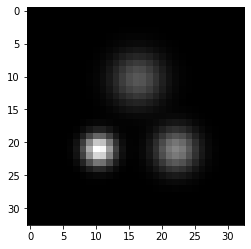

In [616]:
from scipy.stats import multivariate_normal
mu=(-12,10) ; Sigma=(10,10) ; A = multivariate_normal(mu, Sigma).pdf(pos)
mu=(12,10) ; Sigma=(20,20) ; A += multivariate_normal(mu, Sigma).pdf(pos)
mu=(0,-12) ; Sigma=(30,30) ; A += multivariate_normal(mu, Sigma).pdf(pos)
A*=256
plt.imshow(A,cmap='gray')

In [686]:
def shift_zeropad(x,shift):
  assert len(shift) == 2
  sr,sc = shift
  #if np.allclose(shift, np.zeros(2)): return(x)
  
  x = np.roll(x,sr,axis=0)
  
  if sr > 0:
    x[:sr,:] = 0
  elif sr < 0:
    x[sr:,:] = 0
  else: pass
  
  x = np.roll(x,sc,axis=1)
  if sc > 0:
    x[:,:sc] = 0
  elif sc < 0:
    x[:,sc:] = 0
  else: pass
  return(x)

s=10
shift_zeropad(np.arange(s*s).reshape((s,s)),shift=(1,3))

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  2,  3,  4,  5,  6],
       [ 0,  0,  0, 10, 11, 12, 13, 14, 15, 16],
       [ 0,  0,  0, 20, 21, 22, 23, 24, 25, 26],
       [ 0,  0,  0, 30, 31, 32, 33, 34, 35, 36],
       [ 0,  0,  0, 40, 41, 42, 43, 44, 45, 46],
       [ 0,  0,  0, 50, 51, 52, 53, 54, 55, 56],
       [ 0,  0,  0, 60, 61, 62, 63, 64, 65, 66],
       [ 0,  0,  0, 70, 71, 72, 73, 74, 75, 76],
       [ 0,  0,  0, 80, 81, 82, 83, 84, 85, 86]])

In [516]:
def shift_zeropad_axis(x,shift,axis):
  #if np.allclose(shift, np.zeros(2)): return(x)
  
  if axis == 0:
    x = np.roll(x,shift,axis=axis)
    
    if shift > 0:
      x[:shift,:] = 0
    elif shift < 0:
      x[shift:,:] = 0
    else: pass
  
  else:
    x = np.roll(x,shift,axis=axis)
    if shift > 0:
      x[:,:shift] = 0
    elif shift < 0:
      x[:,shift:] = 0
    else: pass
  return(x)

s=10
shift_zeropad_axis(np.arange(s*s).reshape((s,s)),shift=5,axis=0)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]])

In [5]:
s=10
shift_zeropad(np.arange(s*s).reshape((s,s)),shift=(1,3))

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  2,  3,  4,  5,  6],
       [ 0,  0,  0, 10, 11, 12, 13, 14, 15, 16],
       [ 0,  0,  0, 20, 21, 22, 23, 24, 25, 26],
       [ 0,  0,  0, 30, 31, 32, 33, 34, 35, 36],
       [ 0,  0,  0, 40, 41, 42, 43, 44, 45, 46],
       [ 0,  0,  0, 50, 51, 52, 53, 54, 55, 56],
       [ 0,  0,  0, 60, 61, 62, 63, 64, 65, 66],
       [ 0,  0,  0, 70, 71, 72, 73, 74, 75, 76],
       [ 0,  0,  0, 80, 81, 82, 83, 84, 85, 86]])

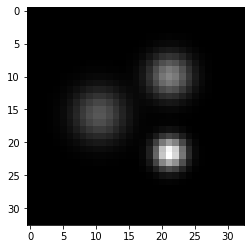

In [517]:
plt.imshow(scipy.ndimage.rotate(A,angle=90),cmap='gray')

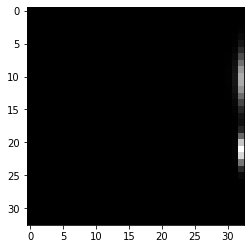

In [518]:

plt.imshow(shift_zeropad(A,shift=(0,30)),cmap='gray')



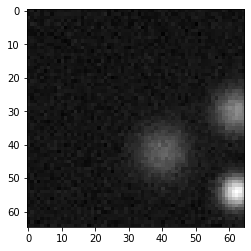

In [225]:
def make_fake(A,sigma,shift,angle=0):
  '''
  sigma_shift: can be 1 (same sigma in x and y) or 2d (different in x and y)
  '''
  #assert len(sigma_shift) == 2
  # angle = np.random.uniform(high=360) # every angle equal
  # if do_rotate: 
  x = scipy.ndimage.rotate(A,angle=angle,reshape=False)
  # else: 

  #shift = np.ceil(sigma_shift*np.random.normal(size=2)).astype(int)
  x=shift_zeropad(x,shift)
  x += np.random.normal(size=A.shape,scale=sigma)
  return(x)

x = make_fake(A.copy(),sigma=0.1,shift=(10,20),angle=90)
plt.imshow(x, cmap='gray')

In [0]:
M=50
sigma=1
sigma_shift=(3,3)
high_angle=360
#true_shifts

Text(0.5, 1.0, 'average image with perfect alignment')

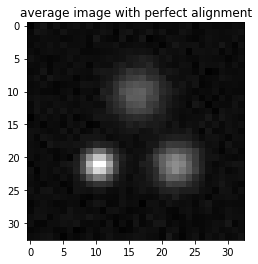

In [664]:
X = np.zeros((M,N,N))
true_shifts = sigma_shift*np.ceil(np.random.normal(size=2*M)).astype(int).reshape(M,2) #np.zeros((M,2),dtype=np.int32)
true_shifts *=0
true_angles = np.random.uniform(size=M,high=high_angle) 
true_angles*=0
for i in range(M):
  X[i,:,:] = make_fake(A.copy(),sigma,shift=true_shifts[i],angle=true_angles[i])

plt.imshow(X.mean(0),cmap='gray')
plt.title('average image with perfect alignment')

Text(0.5, 1.0, 'average of images')

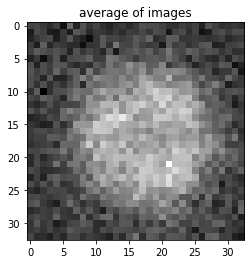

In [665]:
X = np.zeros((M,N,N))
true_shifts = sigma_shift*np.ceil(np.random.normal(size=2*M)).astype(int).reshape(M,2) #np.zeros((M,2),dtype=np.int32)
# true_shifts *=0
true_angles = np.random.uniform(size=M,high=high_angle) 
# true_angles*=0
for i in range(M):
  X[i,:,:] = make_fake(A.copy(),sigma,shift=true_shifts[i],angle=true_angles[i])

plt.imshow(X.mean(0),cmap='gray')
plt.title('average of images')

Text(0.5, 1.0, 'one noisy sample')

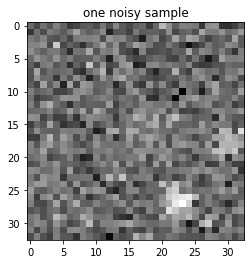

In [666]:
plt.imshow(X[0],cmap='gray')
plt.title('one noisy sample')

# Build equations for algorithm
- table of shifted A
- table of norms of shifted A
- table of pdf of shifts
- loop over samples
  - corr shift A,x; for all x in X
  - compute gi
  - sum over u to get norm factor U
  - accumulate log likelihood
- reverse shift
- sum over i
- update A

## table of shifted A

In [0]:
A_prev = X.mean(0)
#shifts = np.arange(-N,N+1, dtype=np.int32)


In [0]:
shift_span = 10
shifts_r = np.arange(-shift_span+1,shift_span, dtype=np.int32)
shifts_c = np.arange(-shift_span+1,shift_span, dtype=np.int32)
angles = np.arange(0,360,5)
# shifts = np.zeros((2*N+1,2*N+1))
# for shift_r in shifts_:
#   for shift_c in shifts_:
#     shifts[shift_r,shift_c] = [1,2]




Text(0.5, 1.0, 'average of images')

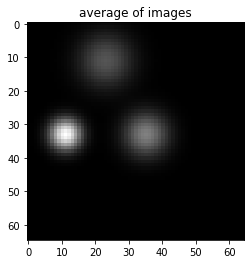

In [230]:
# A_shifted = np.zeros((shifts.shape[0],N,N))
# for shift_idx,shift in enumerate(shifts):
#   A_shifted[shift_idx,:,:] = shift_zeropad(A_prev,shift)

N=65
A_rot_shifted = np.zeros((N,N,angles.shape[0],shifts_r.shape[0],shifts_c.shape[0]),dtype=np.float32)

# M=10
# sigma=0.05
# sigma_shift=(5,5)
# X = np.zeros((M,N,N))
# true_shifts = sigma_shift*np.ceil(np.random.normal(size=2*M)).astype(int).reshape(M,2) #np.zeros((M,2),dtype=np.int32)
# true_angles = np.random.uniform(size=M,high=360) 
for angle_idx, angle in enumerate(angles):
  A_rot = make_fake(A[:N,:N].copy(), sigma=0,shift=(0,0),angle=angle)
  for shift_r_idx, shift_r in enumerate(shifts_r):
    for shift_c_idx, shift_c in enumerate(shifts_c):
      A_rot_shifted[:,:,angle_idx,shift_r_idx,shift_c_idx] = make_fake(A_rot.copy(), sigma=0,shift=(shift_r,shift_c),angle=0)

plt.imshow(A_rot_shifted[:,:,0,0,0],cmap='gray')
plt.title('average of images')


##table of norms of shifted A

In [231]:
A_shifted_norm = np.linalg.norm(A_rot_shifted[:,:,:,:,:],axis=(0,1))**2
A_shifted_norm.shape

(72, 19, 19)

## table of pdf of shifts 
- rotations averages out because uniform

In [0]:
shifts_r_pdf = np.zeros(shifts_r.shape)
for idx,s in enumerate(shifts_r): 
  shifts_r_pdf[idx] = np.exp(-s**2/(2*sigma_shift[0]))*(2*np.pi)**-0.5 #scipy.stats.norm.pdf(s)#

shifts_c_pdf = np.zeros(shifts_c.shape)
for idx,s in enumerate(shifts_c): 
  shifts_c_pdf[idx] = np.exp(-s**2/(2*sigma_shift[1]))*(2*np.pi)**-0.5 #scipy.stats.norm.pdf(s)#


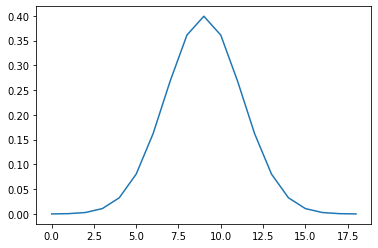

In [233]:
pd.Series(shifts_r_pdf).plot()

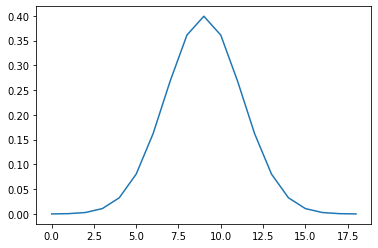

In [234]:
pd.Series(shifts_c_pdf).plot()

## corr shift A,x; exponentiate for gi

In [0]:
x = X[0]
corr_A_x = np.zeros(A_rot_shifted[0,0,:,:,:].shape)

for angle_idx, angle in enumerate(angles):
  for shift_r_idx, shift_r in enumerate(shifts_r):
    for shift_c_idx, shift_c in enumerate(shifts_c):
      corr_A_x[angle_idx,shift_r_idx,shift_c_idx] = np.multiply(A_rot_shifted[:,:,angle_idx,shift_r_idx,shift_c_idx],x).sum() # can replace with on the fly compute of A_rot_shifted

# for idx,a_shifted in enumerate(idx):
#   corr_A_x[idx] = np.multiply(a_shifted,x).sum()
#corr_A_x *= sigma**-2

In [236]:
i=0
true_angles[i], true_shifts[i]

(41.74405054945436, array([0, 5]))

In [238]:
angles[8], shifts_r[9], shifts_c[9+5]

(40, 0, 5)

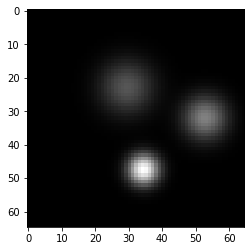

In [241]:
plt.imshow(A_rot_shifted[:,:,8,9,9+5], cmap='gray') # have to reverse shifts

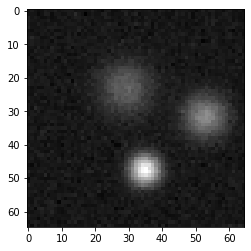

In [240]:
plt.imshow(X[0], cmap='gray')

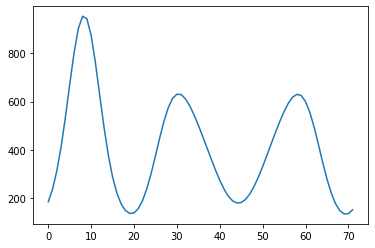

In [284]:
pd.Series(corr_A_x[:,9,9+5]).plot()

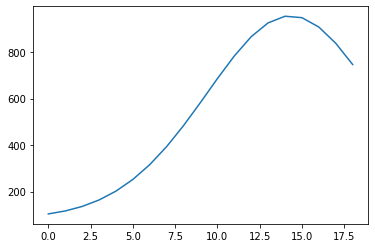

In [285]:
pd.Series(corr_A_x[8,9,:]).plot()

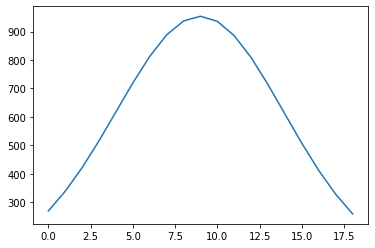

In [286]:
pd.Series(corr_A_x[8,:,9+5]).plot()

In [0]:
# different in 2d?
#sigma = 0.1
A_shifted_norm_  = -(2*sigma**2)**-1*A_shifted_norm
corr_A_x_ = sigma**-2*corr_A_x
#Ki = max(corr_A_x_.max(),A_shifted_norm_.max()) # for numerical stability?
Ki=0
for angle_idx, angle in enumerate(angles):
  for shift_r_idx, shift_r in enumerate(shifts_r):
    for shift_c_idx, shift_c in enumerate(shifts_c):
      Ki_ = A_shifted_norm_[angle_idx,shift_r_idx,shift_c_idx] \
           + corr_A_x_[angle_idx,shift_r_idx,shift_c_idx]
      if Ki_ > Ki: Ki = Ki_

In [288]:
A.max()

4.074406344126306

In [298]:
corr_A_x_.max(),corr_A_x_.min()

(95404.37083010848, 6120.624508575125)

In [290]:
A_shifted_norm_.max(), A_shifted_norm_.min()

(-47772.367, -47857.543)

In [303]:
Ki

47549.300517608484

In [0]:

# do not compute in vectorized form, loop instead
#gi = np.exp(A_shifted_norm_ + corr_A_x_ - Ki)*shift_pdf
gi = np.zeros(A_rot_shifted[0,0,:,:,:].shape)

for angle_idx, angle in enumerate(angles):
  for shift_r_idx, shift_r in enumerate(shifts_r):
    for shift_c_idx, shift_c in enumerate(shifts_c):
      gi[angle_idx,shift_r_idx,shift_c_idx] = np.exp(A_shifted_norm_[angle_idx,shift_r_idx,shift_c_idx] \
                                                     + corr_A_x_[angle_idx,shift_r_idx,shift_c_idx] \
                                                     - Ki)\
                                              * shifts_r_pdf[shift_r_idx] \
                                              * shifts_c_pdf[shift_c_idx]
      


In [305]:
gi.max(), gi.min()

(0.013064233284684923, 0.0)

In [271]:
np.exp(1e2), np.exp(-1e2) # exp ranges [0.01,100]

(2.6881171418161356e+43, 3.720075976020836e-44)

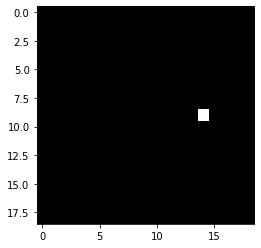

In [306]:
plt.imshow(gi[8,:,:], cmap='gray') # have to reverse shifts

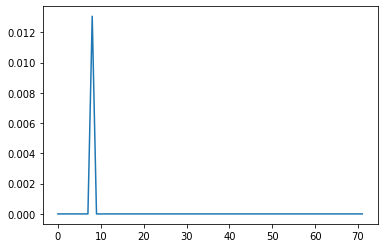

In [307]:
pd.Series(gi[:,9,9+5]).plot()

## sum over u to get norm factor U

In [274]:
Ui = gi.sum()**-1
Ui

76.5448670586961

## accumulate loglikelihood

In [275]:
-np.log(Ui) # sigma factor missing, same for all i

-4.337877066409345

## reverse shift

In [0]:
x_shifted = np.zeros(A_rot_shifted[:,:,:,:,:].shape)

for angle_idx, angle in enumerate(angles):
  for shift_r_idx, shift_r in enumerate(shifts_r):
    for shift_c_idx, shift_c in enumerate(shifts_c):
      x_shifted[:,:,angle_idx,shift_r_idx,shift_c_idx] = make_fake(A.copy(),sigma=0,shift=(-shift_r,-shift_c),angle=angle)

In [331]:
x_shifted.shape, gi.shape

((65, 65, 72, 19, 19), (72, 19, 19))

In [0]:
conv_i = np.multiply(gi,x_shifted[0,0,:,:,:]).sum() 

In [0]:
#scipy.signal.convolve(range(10),range(10),mode='same')

array([ 10,  20,  35,  56,  84, 120, 165, 200, 224, 236])

In [0]:
#scipy.ndimage.convolve(range(10),range(10),mode='constant')

array([ 20,  35,  56,  84, 120, 165, 200, 224, 236, 235])

In [0]:
#scipy.ndimage.convolve1d(range(10),range(10),mode='constant')

array([ 20,  35,  56,  84, 120, 165, 200, 224, 236, 235])

In [0]:
Ui*conv_i

0.14151956676158675

# sum over i to get A next
- per pixel
- have to put together steps from before

In [0]:
# initialize

A_prev = X.mean(0)
A_next = A_prev.copy()

shift_span = 10
shifts_r = np.arange(-shift_span+1,shift_span, dtype=np.int32)
shifts_c = np.arange(-shift_span+1,shift_span, dtype=np.int32)
deg_step = 5
angles = np.arange(0,360,deg_step)

#idx_rand = np.arange(X.shape[0],dtype=np.int32)

In [0]:
n_A_updates=2
fig, axes = plt.subplots(12, n_A_updates,figsize=(8,16))

for c in range(n_A_updates):
  
  ll=0
  A_prev = A_next.copy()
  A_next = np.zeros_like(A_prev)

  axes[0,c].imshow(A_next,cmap='gray') ; axes[0,c].set_axis_off()


  # shift A
  A_rot_shifted = np.zeros((N,N,angles.shape[0],shifts_r.shape[0],shifts_c.shape[0]),dtype=np.float32)
  for angle_idx, angle in enumerate(angles):
    A_rot = make_fake(A_prev.copy(), sigma=0,shift=(0,0),angle=angle)
    for shift_r_idx, shift_r in enumerate(shifts_r):
      for shift_c_idx, shift_c in enumerate(shifts_c):
        A_rot_shifted[:,:,angle_idx,shift_r_idx,shift_c_idx] = make_fake(A_rot.copy(), sigma=0,shift=(shift_r,shift_c),angle=0)


  # norm A
  A_shifted_norm = np.linalg.norm(A_rot_shifted[:,:,:,:,:],axis=(0,1))**2

  # pdf shifts
  shifts_r_pdf = np.zeros(shifts_r.shape)
  for idx,s in enumerate(shifts_r): 
    shifts_r_pdf[idx] = np.exp(-s**2/(2*sigma_shift[0]))*(2*np.pi)**-0.5 #scipy.stats.norm.pdf(s)#

  shifts_c_pdf = np.zeros(shifts_c.shape)
  for idx,s in enumerate(shifts_c): 
    shifts_c_pdf[idx] = np.exp(-s**2/(2*sigma_shift[1]))*(2*np.pi)**-0.5 #scipy.stats.norm.pdf(s)#

  r=0
  best_alignments = np.zeros((M,3))

  for i,x in enumerate(X):
    print('image %i'%i)

    # corr
    corr_A_x = np.zeros(A_rot_shifted[0,0,:,:,:].shape)

    for angle_idx, angle in enumerate(angles):
      for shift_r_idx, shift_r in enumerate(shifts_r):
        for shift_c_idx, shift_c in enumerate(shifts_c):
          corr_A_x[angle_idx,shift_r_idx,shift_c_idx] = np.multiply(A_rot_shifted[:,:,angle_idx,shift_r_idx,shift_c_idx],x).sum() # can replace with on the fly compute of A_rot_shifted

    #max for plotting
    angle_max_idx, shift_r_max_idx, shift_c_max_idx = np.unravel_index(corr_A_x.argmax(), corr_A_x.shape) # +0 -9 -9
    best_alignments[i] = angles[angle_max_idx],shifts_r[shift_r_max_idx],shifts_c[shift_c_max_idx]
    
    #Ki
    A_shifted_norm_  = -(2*sigma**2)**-1*A_shifted_norm
    corr_A_x_ = sigma**-2*corr_A_x
    Ki=0
    for angle_idx, angle in enumerate(angles):
      for shift_r_idx, shift_r in enumerate(shifts_r):
        for shift_c_idx, shift_c in enumerate(shifts_c):
          Ki_ = A_shifted_norm_[angle_idx,shift_r_idx,shift_c_idx] \
              + corr_A_x_[angle_idx,shift_r_idx,shift_c_idx]
          if Ki_ > Ki: Ki = Ki_
    
    # gi
    gi = np.zeros(A_rot_shifted[0,0,:,:,:].shape)
    for angle_idx, angle in enumerate(angles):
      for shift_r_idx, shift_r in enumerate(shifts_r):
        for shift_c_idx, shift_c in enumerate(shifts_c):
          gi[angle_idx,shift_r_idx,shift_c_idx] = np.exp(A_shifted_norm_[angle_idx,shift_r_idx,shift_c_idx] \
                                                        + corr_A_x_[angle_idx,shift_r_idx,shift_c_idx] \
                                                        - Ki)\
                                                  * shifts_r_pdf[shift_r_idx] \
                                                  * shifts_c_pdf[shift_c_idx]

    # Ui
    gisum = gi.sum()
    if not np.isclose(gisum, 0): 
      Ui = gisum**-1
      # log lik
      ll += -np.log(Ui) + Ki - 2*sigma**-2*np.linalg.norm(x)**2 #- N*((M/2+0.5)*np.log(2*pi))
    else: 
      Ui=0

    # rev shift
    x_shifted = np.zeros(A_rot_shifted[:,:,:,:,:].shape)

    for angle_idx, angle in enumerate(angles):
      for shift_r_idx, shift_r in enumerate(shifts_r):
        for shift_c_idx, shift_c in enumerate(shifts_c):
          x_shifted[:,:,angle_idx,shift_r_idx,shift_c_idx] = make_fake(x,sigma=0,shift=(-shift_r,-shift_c),angle=angle)

    conv = np.zeros(A_prev.shape)
    for nr in range(A_prev.shape[0]):
      for nc in range(A_prev.shape[1]):
      # sum over alignments
        conv[nr,nc] = np.multiply(gi,x_shifted[nr,nc,:,:,:]).sum() 
        A_next[nr,nc] += Ui*conv[nr,nc] # perhaps accumulate and sum later... maybe better numerical stability
    
    if True:#i % int(X.shape[0]/10) == 0: 
      print('i = %i, ll = %.2f, A_next max = %.2f' % (i,ll,A_next.max()))
      axes[r+1,c].imshow(A_next,cmap='gray')
      axes[r+1,c].set_axis_off()
      #pd.Series(A_next).plot(ax=axes[r+1,c])
      r+=1

  A_next *= N**-1
  #pd.Series(A).plot(ax=axes[r+1,c])
  axes[r+1,c].imshow(A,cmap='gray')
  axes[r+1,c].set_axis_off()


# `numba.jit`
- speed up: the unoptimized code takes tens of second for each image. 
- the loops can be `numba.jit`-ed 
- the rotation and shifting can be refactored
- remove `.copy()` steps 

## helper functions

In [432]:
@numba.jit
def comp_corr(A_rot_shifted,x):
  corr_A_x = np.zeros(A_rot_shifted[0,0,:,:,:].shape)
  for angle_idx in range(A_rot_shifted.shape[2]):
    for shift_r_idx in range(A_rot_shifted.shape[3]):
      for shift_c_idx in range(A_rot_shifted.shape[4]):
        corr_A_x[angle_idx,shift_r_idx,shift_c_idx] = np.multiply(A_rot_shifted[:,:,angle_idx,shift_r_idx,shift_c_idx],x).sum() # can replace with on the fly compute of A_rot_shifted
  return(corr_A_x)
%time _ = comp_corr(A_rot_shifted,x)

CPU times: user 1.65 s, sys: 0 ns, total: 1.65 s
Wall time: 1.66 s


In [433]:
@numba.jit
def comp_Ki(A_shifted_norm_,corr_A_x_):
  Ki=0
  for angle_idx in range(A_shifted_norm_.shape[0]):
    for shift_r_idx in range(A_shifted_norm_.shape[1]):
      for shift_c_idx in range(A_shifted_norm_.shape[2]):
          Ki_ = A_shifted_norm_[angle_idx,shift_r_idx,shift_c_idx] \
              + corr_A_x_[angle_idx,shift_r_idx,shift_c_idx]
          if Ki_ > Ki: Ki = Ki_
  return(Ki)
%time _ = comp_Ki(A_shifted_norm_,corr_A_x_)

CPU times: user 171 ms, sys: 2 ms, total: 173 ms
Wall time: 173 ms


In [536]:
@numba.jit
def comp_gi(A_shifted_norm_,corr_A_x_,Ki,shifts_r_pdf,shifts_c_pdf):
  gi = np.zeros(A_shifted_norm_.shape)
  for angle_idx in range(A_shifted_norm_.shape[0]):
    for shift_r_idx in range(A_shifted_norm_.shape[1]):
      for shift_c_idx in range(A_shifted_norm_.shape[2]):
          gi[angle_idx,shift_r_idx,shift_c_idx] = np.exp(A_shifted_norm_[angle_idx,shift_r_idx,shift_c_idx] \
                                                        + corr_A_x_[angle_idx,shift_r_idx,shift_c_idx] \
                                                        - Ki)\
                                                  * shifts_r_pdf[shift_r_idx] \
                                                  * shifts_c_pdf[shift_c_idx]
  return(gi)
%time _ = comp_gi(A_shifted_norm_,corr_A_x_,Ki,shifts_r_pdf,shifts_c_pdf)

CPU times: user 249 ms, sys: 4 ms, total: 253 ms
Wall time: 254 ms


In [742]:
def comp_x_aligned(x,A_rot_shifted,angles,shifts_r,shifts_c):
  x_aligned = np.zeros(A_rot_shifted[:,:,:,:,:].shape)
  for angle_idx in range(angles.shape[0]):
    x_rot = scipy.ndimage.rotate(x,angle=-angles[angle_idx],reshape=False) 
    for shift_r_idx in range(shifts_r.shape[0]):
      x_rot_shift = shift_zeropad_axis(x_rot,shift=-shifts_r[shift_r_idx],axis=0)
      for shift_c_idx in range(shifts_c.shape[0]):
          x_aligned[:,:,angle_idx,shift_r_idx,shift_c_idx] = shift_zeropad_axis(x_rot_shift,shift=-shifts_c[shift_c_idx],axis=1)
  return(x_aligned)
%time _ = comp_x_aligned(x,A_rot_shifted,angles,shifts_r,shifts_c)

CPU times: user 1.8 s, sys: 1e+03 µs, total: 1.8 s
Wall time: 1.8 s


In [661]:
@numba.jit
def comp_A_next(A_prev,A_next,x_aligned,gi,Ui):
    conv = np.zeros(A_prev.shape)
    for nr in range(A_prev.shape[0]):
      for nc in range(A_prev.shape[1]):
      # sum over alignments
        conv[nr,nc] = np.multiply(gi,x_aligned[nr,nc,:,:,:]).sum() 
        A_next[nr,nc] += Ui*conv[nr,nc]
    #A_next*=Ui # for some reason blows up when leave this step to the end
    return(A_next)

%time _ = comp_A_next(A_prev,A_next,x_aligned,gi=gi,Ui=Ui)

CPU times: user 602 ms, sys: 6 ms, total: 608 ms
Wall time: 609 ms


## refactored algorithm

In [0]:
# initialize

A_prev = X.mean(0)
A_next = A_prev.copy()

shift_span = 10
shifts_r = np.arange(-shift_span+1,shift_span, dtype=np.int32)
shifts_c = np.arange(-shift_span+1,shift_span, dtype=np.int32)
deg_step = 3
angles = np.arange(0,360,deg_step)

#idx_rand = np.arange(X.shape[0],dtype=np.int32)

A_shifted_norm_ max -47.03 | A_shifted_norm_ min -112.50
i = 0, ll = -2530.48, A_next max = 4.72
i = 5, ll = -15201.58, A_next max = 26.75
i = 10, ll = -27838.74, A_next max = 48.70
i = 15, ll = -40434.57, A_next max = 66.78
i = 20, ll = -53157.04, A_next max = 83.44
i = 25, ll = -65455.18, A_next max = 103.62
i = 30, ll = -77852.64, A_next max = 120.46
i = 35, ll = -90085.73, A_next max = 141.58
i = 40, ll = -102940.48, A_next max = 159.43
i = 45, ll = -115030.42, A_next max = 180.10
A_shifted_norm_ max -47.03 | A_shifted_norm_ min -112.50
i = 0, ll = -2530.48, A_next max = 4.72
i = 5, ll = -15201.58, A_next max = 26.75
i = 10, ll = -27838.74, A_next max = 48.70
i = 15, ll = -40434.57, A_next max = 66.78
i = 20, ll = -53157.04, A_next max = 83.44
i = 25, ll = -65455.18, A_next max = 103.62
i = 30, ll = -77852.64, A_next max = 120.46
i = 35, ll = -90085.73, A_next max = 141.58
i = 40, ll = -102940.48, A_next max = 159.43
i = 45, ll = -115030.42, A_next max = 180.10
A_shifted_norm_ max 

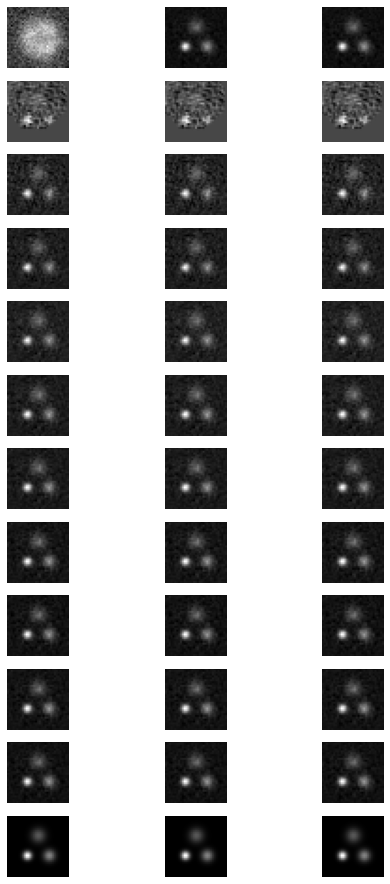

In [744]:
n_A_updates=3
fig, axes = plt.subplots(12, n_A_updates,figsize=(8,16))

for c in range(n_A_updates):
  
  ll=0
  A_prev = A_next.copy()
  A_next = np.zeros_like(A_prev)

  axes[0,c].imshow(A_prev,cmap='gray') ; axes[0,c].set_axis_off()


  # alignment library of A
  A_rot_shifted = np.zeros((N,N,angles.shape[0],shifts_r.shape[0],shifts_c.shape[0]),dtype=np.float32)

  for shift_r_idx, shift_r in enumerate(shifts_r):
    A_shift_r = shift_zeropad_axis(A,shift=shift_r,axis=0)
    for shift_c_idx, shift_c in enumerate(shifts_c):
      A_shift_r_c = shift_zeropad_axis(A_shift_r,shift=shift_c,axis=1)
      for angle_idx, angle in enumerate(angles):
        A_rot_shifted[:,:,angle_idx,shift_r_idx,shift_c_idx] = scipy.ndimage.rotate(A_shift_r_c,angle=angle,reshape=False) # rotation in inner loop, so rotation in outer loop for each image


  # norm A
  A_shifted_norm = np.linalg.norm(A_rot_shifted[:,:,:,:,:],axis=(0,1))**2
  A_shifted_norm_  = -(2*sigma**2)**-1*A_shifted_norm
  print('A_shifted_norm_ max %.2f | A_shifted_norm_ min %.2f' % (A_shifted_norm_.max(), A_shifted_norm_.min()) )


  # pdf shifts
  shifts_r_pdf = np.zeros(shifts_r.shape)
  for idx,s in enumerate(shifts_r): 
    shifts_r_pdf[idx] = np.exp(-s**2/(2*sigma_shift[0]))*(2*np.pi)**-0.5 #scipy.stats.norm.pdf(s)#

  shifts_c_pdf = np.zeros(shifts_c.shape)
  for idx,s in enumerate(shifts_c): 
    shifts_c_pdf[idx] = np.exp(-s**2/(2*sigma_shift[1]))*(2*np.pi)**-0.5 #scipy.stats.norm.pdf(s)#

  r=0
  best_alignments = np.zeros((M,3))

  for i,x in enumerate(X):
    #print('image %i'%i)

    # corr
    corr_A_x = comp_corr(A_rot_shifted,x)
    #print('corr_A_x max %.2f | corr_A_x min %.2f' % (corr_A_x.max(), corr_A_x.min()) )

    #max for plotting
    angle_max_idx, shift_r_max_idx, shift_c_max_idx = np.unravel_index(corr_A_x.argmax(), corr_A_x.shape) # +0 -9 -9
    best_alignments[i] = angles[angle_max_idx],shifts_r[shift_r_max_idx],shifts_c[shift_c_max_idx]
    
    #Ki
    corr_A_x_ = sigma**-2*corr_A_x
    Ki=comp_Ki(A_shifted_norm_,corr_A_x_)
    #Ki = max(A_shifted_norm_.max(),corr_A_x_.max())
    #print('Ki %.2f' % Ki)
    
    
    # gi
    gi = comp_gi(A_shifted_norm_,corr_A_x_,Ki,shifts_r_pdf,shifts_c_pdf)
    #print('gi max %.2f | gi min %.2f' % (gi.max(), gi.min()) )

    # Ui
    gisum = gi.sum()
    if not np.isclose(gisum, 0): 
      Ui = gisum**-1
      # log lik
      ll += -np.log(Ui) + Ki - 2*sigma**-2*np.linalg.norm(x)**2 #- N*((M/2+0.5)*np.log(2*pi))
    else: 
      Ui=0
    #print('Ui %.2f' % Ui)

    # rev align
    x_aligned = comp_x_aligned(x,A_rot_shifted,angles,shifts_r,shifts_c)
    
    # A_next
    A_next = comp_A_next(A_prev,A_next,x_aligned,gi,Ui)
    
    if i % int(X.shape[0]/10) == 0: 
      print('i = %i, ll = %.2f, A_next max = %.2f' % (i,ll,A_next.max()))
      axes[r+1,c].imshow(A_next,cmap='gray')
      #axes[r+1,c].title.set_text('A_next max = %.2f' % A_next.max())
      axes[r+1,c].set_axis_off()
      #pd.Series(A_next).plot(ax=axes[r+1,c])
      r+=1

  A_next *= (A_next.size)**-1
  #pd.Series(A).plot(ax=axes[r+1,c])
  axes[r+1,c].imshow(A,cmap='gray')
  axes[r+1,c].set_axis_off()


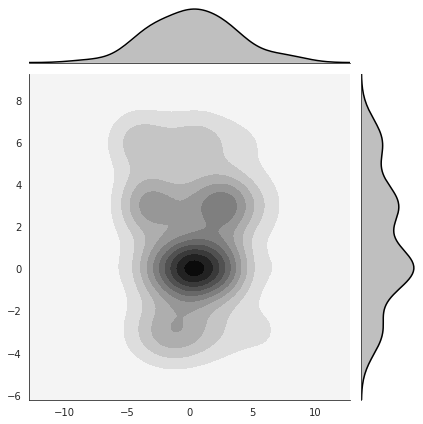

In [752]:
with sns.axes_style("white"):
    sns.jointplot(x=best_alignments[:,2], y=true_shifts[:,1], kind="kde", color="k");

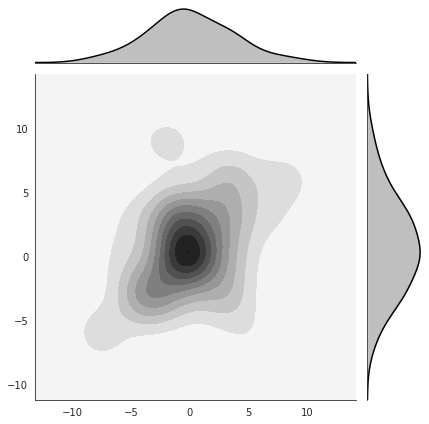

In [753]:
with sns.axes_style("white"):
    sns.jointplot(x=best_alignments[:,1], y=true_shifts[:,0], kind="kde", color="k");

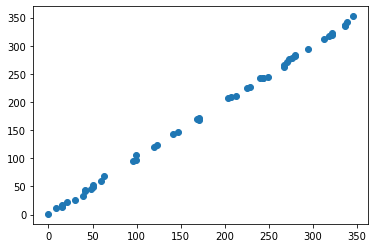

In [747]:
plt.scatter(best_alignments[:,0],true_angles[:])

# Performance limit
- the gridding of the angles, and the noise prevents perfect recapitulation of the data. 
- in the limit of perfect shift estimate, and nearest angle on grid point estimate

In [702]:
def myround(x, base=3):
    return base * round(float(x) / base)


3

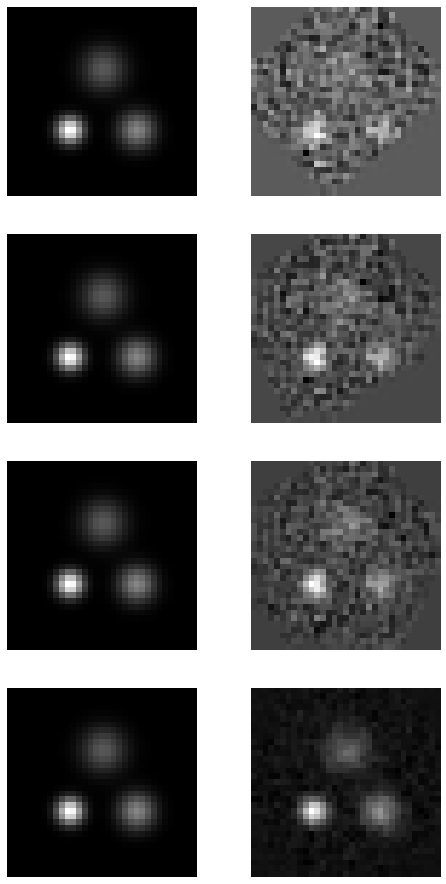

In [749]:
fig, axes = plt.subplots(4, 2,figsize=(8,16))
x_deshifted_derot = np.zeros_like(X[0])
r=0
for true_idx in range(M):
  x = X[true_idx]
  #x_denoised = make_fake(A,sigma=0,shift=true_shifts[true_idx],angle=true_angles[true_idx])
  x_deshifted = make_fake(x,sigma=0,shift=-true_shifts[true_idx],angle=0)
  x_deshifted_derot += make_fake(x_deshifted,sigma=0,shift=(0,0),angle=-myround(true_angles[true_idx],base=deg_step)) 

  if true_idx < 3:
    axes[r,0].imshow(A,cmap='gray') ; axes[r,0].set_axis_off()
    axes[r,1].imshow(x_deshifted_derot,cmap='gray') ; axes[r,1].set_axis_off()
    r+=1
axes[r,0].imshow(A,cmap='gray') ; axes[r,0].set_axis_off()
axes[r,1].imshow(x_deshifted_derot,cmap='gray') ; axes[r,1].set_axis_off()